<a href="https://colab.research.google.com/github/madhugraj/research/blob/master/Vae_Flash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

import os
import tensorflow_datasets as tfds

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
print("Done")
'''
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution 
'''

INFO:tensorflow:Initializing the TPU system: grpc://10.62.46.186:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.62.46.186:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Done


"\n# Detect hardware, return appropriate distribution strategy\ntry:\n    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.\n    print('Running on TPU ', tpu.master())\nexcept ValueError:\n    tpu = None\n\nif tpu:\n    tf.config.experimental_connect_to_cluster(tpu)\n    tf.tpu.experimental.initialize_tpu_system(tpu)\n    strategy = tf.distribute.experimental.TPUStrategy(tpu)\nelse:\n    strategy = tf.distribute.get_strategy() # default distribution \n"

In [2]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization
from keras.models import Model
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import glob,cv2
from keras.preprocessing.image import load_img,array_to_img,img_to_array


Using TensorFlow backend.


In [3]:
batch_size = 16*tpu_strategy.num_replicas_in_sync
no_epochs = 100
validation_split = 0.2
verbosity = 1
latent_dim = 2
num_channels = 1
batch_size

128

In [6]:

!unzip '/content/drive/My Drive/flash_data/Small_Data.zip'
!unzip '/content/drive/My Drive/flash_data/test.zip'

x_train2= sorted(glob.glob(r'/content/Small_Data/*.*'))
valid_data= sorted(glob.glob(r'/content/test/*.*'))

Streaming output truncated to the last 5000 lines.
  inflating: Small_Data/bibliomanism.png  
  inflating: Small_Data/bienness.png  
  inflating: Small_Data/bifidities.png  
  inflating: Small_Data/bigamy.png   
  inflating: Small_Data/bigaroon.png  
  inflating: Small_Data/bigoniac.png  
  inflating: Small_Data/bilharziosis.png  
  inflating: Small_Data/bilipyrrhin.png  
  inflating: Small_Data/billholder.png  
  inflating: Small_Data/bimarginate.png  
  inflating: Small_Data/binal.png    
  inflating: Small_Data/biog.png     
  inflating: Small_Data/biogas.png   
  inflating: Small_Data/biotypes.png  
  inflating: Small_Data/birdcalls.png  
  inflating: Small_Data/bisglyoxaline.png  
  inflating: Small_Data/Biskra.png   
  inflating: Small_Data/bistros.png  
  inflating: Small_Data/bitake.png   
  inflating: Small_Data/bitter-.png  
  inflating: Small_Data/bittersweets.png  
  inflating: Small_Data/bitumens.png  
  inflating: Small_Data/Bjork.png    
  inflating: Small_Data/bklr.png 

In [7]:
x_train2[421]

'/content/Small_Data/Korah.png'

In [8]:
## Test for normalization

from google.colab.patches import cv2_imshow
def img_preprocess1(img):
    img=load_img(img,color_mode='grayscale',target_size=(512,512))
    img=img_to_array(img).astype('float32')
    #print(img)
    #cv2_imshow(img)
    mean, stdDev = cv2.meanStdDev(img)  #Get Mean and Standard-deviation
    image = (img-mean)/stdDev  #Normalization process
    image -= image.min() 
    image /= image.max()
    #cv2_imshow(image)
    return image
#print(img_preprocess(x_train2[1]))
#cv2_imshow(img_preprocess1(x_train2[421]))

In [9]:
## preparing the datadet for training and testing
from tqdm import tqdm

## np array for the images- Train and Valid dataset

x_tr =[]
valid =[]

def img_preprocess(img):
    img=load_img(img,color_mode='grayscale',target_size=(256,256))
    img=img_to_array(img).astype('float32')

    #mean, stdDev = cv2.meanStdDev(img)  #Get Mean and Standard-deviation
    #image = (img-mean)/stdDev  #Normalization process
    #image -= image.min() 
    #image /= image.max()
    return img

for img in tqdm(x_train2):
    x_tr.append(img_preprocess(img))
    
x_tr= np.array(x_tr)
 
for img in tqdm(valid_data):
    valid.append(img_preprocess(img))
    
valid= np.array(valid)

print('Train Shape:',x_tr.shape)
print('Test Shape:',valid.shape)


100%|██████████| 498/498 [00:12<00:00, 39.77it/s]


Train Shape: (4973, 256, 256, 1)
Test Shape: (498, 256, 256, 1)


In [10]:
## 
img_height =256
img_width =256

# Reshape data
input_train = x_tr.reshape(x_tr.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')

# Normalize data
input_train = input_train / 255
#input_train[1]

In [11]:
## Encoder


input_layer = Input(shape=input_shape, name='Encoder_input')

conv_1     = Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(input_layer)
conv_1      = BatchNormalization()(conv_1)

conv_2      = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(conv_1)
conv_2      = BatchNormalization()(conv_2)

conv_3      = Conv2D(filters=32, kernel_size=1, strides=2, padding='same', activation='relu')(conv_2)
conv_3      = BatchNormalization()(conv_3)

Flat       = Flatten()(conv_3)
Dens       = Dense(100, activation='relu')(Flat)
Dens       = BatchNormalization()(Dens)
mu      = Dense(latent_dim, name='latent_mu')(Dens)
sigma   = Dense(latent_dim, name='latent_sigma')(Dens)

# Get Conv2D shape for Conv2DTranspose operation in decoder
conv_shape = K.int_shape(conv_3)
#conv_shape

def sample_z(args):
  mu, sigma = args
  batch     = K.shape(mu)[0]
  dim       = K.int_shape(mu)[1]
  eps       = K.random_normal(shape=(batch, dim))
  return mu + K.exp(sigma / 2) * eps

# Use reparameterization trick to ....??
z       = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

encoder = Model(input_layer, [mu, sigma, z], name='encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_input (InputLayer)      (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  80          Encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 8)  32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 16)   1168        batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [12]:
# Decoder
decoder_input   = Input(shape=(latent_dim, ), name='decoder_input')
decode_dense     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(decoder_input)
decode_dense     = BatchNormalization()(decode_dense)
decode_dense    = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decode_dense)

Decode_3    = Conv2DTranspose(filters=32, kernel_size=1, strides=2, padding='same',  activation='relu')(decode_dense)
Decode_3    = BatchNormalization()(Decode_3)

Decode_2    = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(Decode_3)
Decode_2    = BatchNormalization()(Decode_2)

Decode_1    = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same',  activation='relu')(Decode_2)
Decode_1    = BatchNormalization()(Decode_1)



output_decode  = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(Decode_1)

# Instantiate decoder
decoder = Model(decoder_input, output_decode, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 32768)             98304     
_________________________________________________________________
batch_normalization_5 (Batch (None, 32768)             131072    
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 32)        1056      
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 128, 128, 16)      4624

In [13]:
# Variational_Autoencoder

vae_outputs = decoder(encoder(input_layer)[2])
vae         = Model(input_layer, vae_outputs, name='V_Autoencoder')
vae.summary()

Model: "V_Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder_input (InputLayer)   (None, 256, 256, 1)       0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 3279720   
_________________________________________________________________
decoder (Model)              (None, 256, 256, 1)       236513    
Total params: 3,516,233
Trainable params: 3,450,273
Non-trainable params: 65,960
_________________________________________________________________


In [14]:
# Define loss: 30% Binary cross entropy, 70% KL divergence


def kl_reconstruction_loss(true, pred):
  # Reconstruction loss
  reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
  # KL divergence loss
  kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.3
  #Total loss = 30% rec + 70% KL divergence loss
  return K.mean(reconstruction_loss + kl_loss)
  #return  kl_loss

In [ ]:
#vae.load_weights(r'/content/drive/My Drive/Weights/vae_Flash.h5')

In [15]:
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)


In [16]:
# Train autoencoder
vae.fit(input_train, input_train, epochs = 500, batch_size = batch_size, validation_split = validation_split)

Train on 3978 samples, validate on 995 samples
Epoch 1/500
3978/3978 [==============================] - 53s 13ms/step - loss: 46115.3200 - val_loss: 41053.0332
Epoch 2/500
3978/3978 [==============================] - 52s 13ms/step - loss: 38158.3613 - val_loss: 33250.4604
Epoch 3/500
3978/3978 [==============================] - 52s 13ms/step - loss: 26569.7636 - val_loss: 22827.3131
Epoch 4/500
3978/3978 [==============================] - 52s 13ms/step - loss: 16497.8424 - val_loss: 12584.3451
Epoch 5/500
3978/3978 [==============================] - 52s 13ms/step - loss: 10498.8491 - val_loss: 9028.9667
Epoch 6/500
3978/3978 [==============================] - 52s 13ms/step - loss: 7718.1007 - val_loss: 7692.9043
Epoch 7/500
3978/3978 [==============================] - 52s 13ms/step - loss: 6366.8712 - val_loss: 7124.0480
Epoch 8/500
3978/3978 [==============================] - 52s 13ms/step - loss: 5659.6133 - val_loss: 6950.8592
Epoch 9/500
3978/3978 [==============================] -

In [17]:
vae.save(r'/content/drive/My Drive/Weights/vae_Flash_v4.h5')

In [ ]:
#vae.load_weights(r'/content/drive/My Drive/Weights/vae_Flash.h5')

In [25]:
def viz_latent_space(encoder, data):
  input_data, target_data = data
  mu, _, _ = encoder.predict(input_data)
  plt.figure(figsize=(8, 10))
  plt.scatter(mu[:, 0], mu[:, 1], c=mu)
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  plt.colorbar()
  plt.show()

In [22]:
def viz_decoded(encoder, decoder, data):
  num_samples = 1
  figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
  grid_x = np.linspace(-4, 4, num_samples)
  grid_y = np.linspace(-4, 4, num_samples)[::-1]
  for i, yi in enumerate(grid_y):
      for j, xi in enumerate(grid_x):
          z_sample = np.array([[xi, yi]])
          x_decoded = decoder.predict(z_sample)
         # print("predicted!")
          digit = x_decoded[0].reshape(img_width, img_height, num_channels)
          figure[i * img_width: (i + 1) * img_width,
                  j * img_height: (j + 1) * img_height] = digit
  plt.figure(figsize=(10, 10))
  start_range = img_width // 2
  end_range = num_samples * img_width + start_range + 1
  pixel_range = np.arange(start_range, end_range, img_width)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  # matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
  # So reshape if necessary
  fig_shape = np.shape(figure)
  if fig_shape[2] == 1:
    figure = figure.reshape((fig_shape[0], fig_shape[1]))
  # Show image
  plt.imshow(figure)
  plt.show()

ValueError: ignored

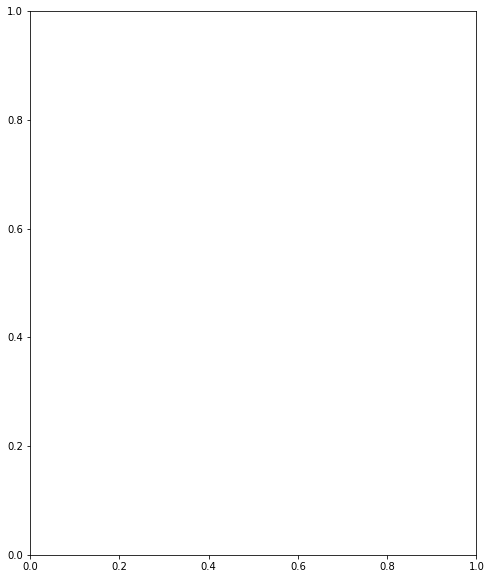

In [26]:
viz_latent_space(encoder, data)

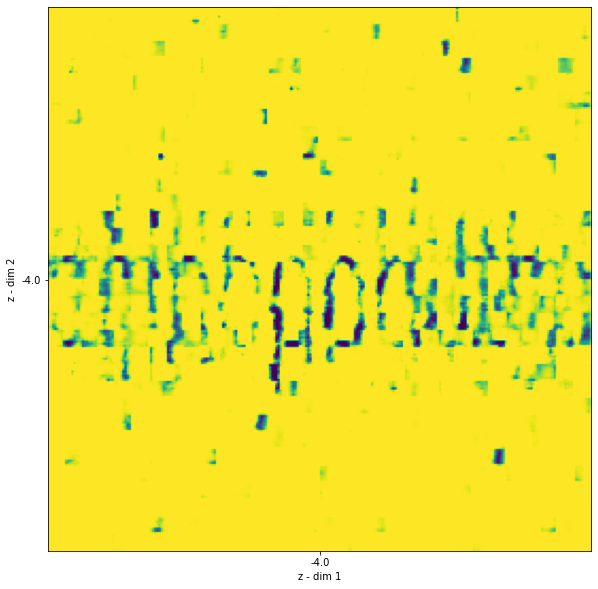

In [23]:
# Plot results
data = (input_train, input_train)
#viz_latent_space(encoder, data)
viz_decoded(encoder, decoder, data)

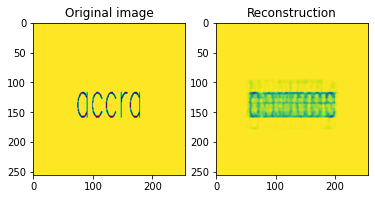

In [21]:
# Vizualisation

input_sample = input_train[:1]
reconstruction = vae.predict([input_sample])

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(6, 3.5)
input_sample_reshaped = input_sample.reshape((img_width, img_height))
reconsstruction_reshaped = reconstruction.reshape((img_width, img_height))
axes[0].imshow(input_sample_reshaped) 
axes[0].set_title('Original image')
axes[1].imshow(reconsstruction_reshaped)
axes[1].set_title('Reconstruction')
plt.show()